<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/coding_trees/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [2]:
import os
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from DeepBSDE.main import main as deep_bsde

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def simulate_mc_and_plot(model, exact_example=None, nb_spatial=10, repeats=1, return_mc=False, plt_and_save=True):
    if not os.path.isdir('logs/'):
        os.makedirs('logs/')
    tx = torch.zeros(nb_spatial, model.dim_in + 1, device=device)
    tx[:, -1] = torch.linspace(model.x_lo, model.x_hi, nb_spatial)
    mc = 0
    for _ in range(repeats):
        x, y = model.gen_sample(patch=0, tx=tx)
        mc += y[:, 0].cpu()
    mc /= repeats
    
    # original grid for mc
    mc_grid = tx[:, -1].cpu()
   
    # can't plot & save when exact_example is not given
    plt_and_save = False if exact_example is None else plt_and_save
    if plt_and_save:
         # finer grid for exact solution
        x = np.zeros((model.dim_in, 10 * nb_spatial))
        exact_grid = np.linspace(model.x_lo, model.x_hi, 10 * nb_spatial)
        x[-1] = exact_grid

        # plot
        plt.scatter(mc_grid, mc, s=50, facecolors='none', edgecolors='black', label='MC')
        exact = exact_example(t=0, x=x, T=T, coordinate=0)
        terminal = exact_example(t=T, x=x, T=T, coordinate=0)
        plt.plot(exact_grid, exact, color='black', label='exact')
        plt.plot(exact_grid, terminal, '--',color='black', label='terminal')
        plt.legend()
        plt.show()

        np.savetxt(
            "logs/plt_" + model.problem_name + "_fine.csv",
            np.stack((exact_grid, exact, terminal), axis=-1),
            delimiter=",",
            header="x, true, terminal",
            comments="",
        )
        np.savetxt(
            "logs/plt_" + model.problem_name + "_coarse.csv",
            np.stack((mc_grid, mc), axis=-1),
            delimiter=",",
            header="x, branch",
            comments="",
        )
    
    if return_mc:
        return mc_grid, mc

## Allen Cahn Equation (5.1)

In [3]:
problem_name = "allen_cahn_weinan"
nu = 2

fixed_dim, dim = 0, 100

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return 1 / (2 + 2/5 * (x ** 2).sum(dim=0))

x_lo, x_hi = 0., 0.

In [8]:
patches = 1
T = patches * .3

nb_mc = 5  # weinan ran 5 independent runs for Table 1

# define NN and train
start = time.time()
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
x, mc = simulate_mc_and_plot(model, nb_spatial=nb_mc, return_mc=True, repeats=10)
mc = mc.numpy()
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


fdb time: 0.1 seconds; total time: 37.0 seconds; time without fdb: 36.9 seconds.


In [9]:
true_sol = 0.052802  # this is given by Weinan
error = np.abs(mc - true_sol) / true_sol

weinan = [0.0528, 0.0002, 0.0030, 0.0022, 647]
branch = [mc.mean(), mc.std(), error.mean(), error.std(), time_without_fdb // nb_mc]
df = pd.DataFrame({'weinan Table 1': weinan, 'branch': branch}).T
df.columns = ['mean of solution', 'std of solution', 'mean of L1 relative error', 'std of L1 relative error', 'mean of runtime']
df.T

,weinan Table 1,branch
mean of solution,0.0528,0.052754
std of solution,0.0002,0.000364
mean of L1 relative error,0.0030,0.005916
std of L1 relative error,0.0022,0.003661
mean of runtime,647.0000,7.000000


## HJB Equation (5.8)

In [29]:
problem_name = "hjb_weinan"
nu = 2

fixed_dim, dim = 0, 100

# function definition
deriv_map = np.identity(dim).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0 to d-1 -> first deriv
    """
    return -(y ** 2).sum(dim=0)

def phi_example(x, coordinate=0):
    return torch.log((1 + (x ** 2).sum(dim=0)) / 2)

x_lo, x_hi = 0., 0.

In [30]:
patches = 1
T = patches * 1

nb_mc = 5  # weinan ran 5 independent runs for Table 1
time_list, mc_list = [], []

# define NN and train
start = time.time()
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
x, mc = simulate_mc_and_plot(model, nb_spatial=nb_mc, return_mc=True)
mc = mc.numpy()
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


fdb time: 4124.7 seconds; total time: 4855.3 seconds; time without fdb: 730.6 seconds.


In [31]:
true_sol = 4.5901  # this is given by Weinan
error = np.abs(mc - true_sol) / true_sol

weinan = [4.5977, 0.0019, 0.0017, 0.0004, 330]
branch = [mc.mean(), mc.std(), error.mean(), error.std(), time_without_fdb // nb_mc]
df = pd.DataFrame({'weinan Table 2': weinan, 'branch': branch}).T
df.columns = ['mean of solution', 'std of solution', 'mean of L1 relative error', 'std of L1 relative error', 'mean of runtime']
df.T

,weinan Table 2,branch
mean of solution,4.5977,4.580340
std of solution,0.0019,0.001869
mean of L1 relative error,0.0017,0.002126
std of L1 relative error,0.0004,0.000407
mean of runtime,330.0000,146.000000


## Allen Cahn Equation (5.2) - Blow Up Analysis

In [4]:
def blow_up_analysis(T_arr, dim, problem_name, deriv_map, f_example, phi_example, exact_example):
    df = []
    for T in T_arr:
        print(f"Now dealing with T = {T}...")
        # initialize branching model
        torch.manual_seed(0)
        model = Net(
            problem_name=problem_name,
            f_fun=f_example,
            deriv_map=deriv_map,
            phi_fun=phi_example,
            device=device,
            x_lo=0,
            x_hi=0,
            T=T,
            verbose=True,
            branch_nb_path_per_state=100000,
            save_as_tmp=True,
        )
        tx = torch.zeros(1, model.dim_in + 1, device=device)
        
        # branching mc calculation
        start = time.time()
        mc, repeats = 0, 10
        for _ in range(repeats):
            x, y = model.gen_sample(patch=0, tx=tx)
            mc += y[:, 0].cpu()
        mc = mc[0].item() / repeats
        mc_time = time.time() - start
        
        # exact calculation & bsde calculation
        exact = exact_example(t=0, x=np.zeros((model.dim_in, 1)), T=T, coordinate=0)[0]
        start = time.time()
        bsde = deep_bsde(total_time=T, verbose=False, dim=dim, y_init_range=[-1, 0])[-1][2]
        bsde_time = time.time() - start
        
        df.append([T, mc, bsde, exact, mc_time, bsde_time])
    
    # create df & save
    if not os.path.isdir('logs/'):
        os.makedirs('logs/')
    df = pd.DataFrame(df, columns=['T', 'branch', 'deep_bsde', 'exact', 'branch time (seconds)', 'deep_bsde time (seconds)'])
    df.to_csv("logs/" + problem_name + ".csv")
    
    return df

### Dimension d = 1

In [6]:
fixed_dim, dim = 0, 1

problem_name = f"allen_cahn_jeeq_dim_{dim}_blow_up_analysis"

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T, coordinate=0):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

delta_t = 0.05
T_arr = np.arange(delta_t, 2 + delta_t, delta_t)
df = blow_up_analysis(
    T_arr=T_arr,
    dim=dim,
    problem_name=problem_name,
    deriv_map=deriv_map,
    f_example=f_example,
    phi_example=phi_example,
    exact_example=exact_example
)

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.05...


Begin to solve AllenCahn 
Y0_true: -5.1874e-01
relative error of Y0: -0.00%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.1...


Begin to solve AllenCahn 
Y0_true: -5.3743e-01
relative error of Y0: -0.01%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.15000000000000002...


Begin to solve AllenCahn 
Y0_true: -5.5601e-01
relative error of Y0: -0.01%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.2...


Begin to solve AllenCahn 
Y0_true: -5.7444e-01
relative error of Y0: -0.02%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.25...


Begin to solve AllenCahn 
Y0_true: -5.9267e-01
relative error of Y0: -0.03%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.3...


Begin to solve AllenCahn 
Y0_true: -6.1064e-01
relative error of Y0: -5.39%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.35000000000000003...


Begin to solve AllenCahn 
Y0_true: -6.2832e-01
relative error of Y0: -0.04%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.4...


Begin to solve AllenCahn 
Y0_true: -6.4566e-01
relative error of Y0: -0.05%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.45...


Begin to solve AllenCahn 
Y0_true: -6.6262e-01
relative error of Y0: -22.45%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.5...


Begin to solve AllenCahn 
Y0_true: -6.7918e-01
relative error of Y0: -0.05%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.55...


Begin to solve AllenCahn 
Y0_true: -6.9530e-01
relative error of Y0: -0.03%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.6000000000000001...


Begin to solve AllenCahn 
Y0_true: -7.1095e-01
relative error of Y0: -61.98%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.6500000000000001...


Begin to solve AllenCahn 
Y0_true: -7.2611e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.7000000000000001...


Begin to solve AllenCahn 
Y0_true: -7.4077e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.7500000000000001...


Begin to solve AllenCahn 
Y0_true: -7.5491e-01
relative error of Y0: -42.55%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.8...


Begin to solve AllenCahn 
Y0_true: -7.6852e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.8500000000000001...


Begin to solve AllenCahn 
Y0_true: -7.8160e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.9000000000000001...


Begin to solve AllenCahn 
Y0_true: -7.9413e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.9500000000000001...


Begin to solve AllenCahn 
Y0_true: -8.0612e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.0...


Begin to solve AllenCahn 
Y0_true: -8.1757e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.05...


Begin to solve AllenCahn 
Y0_true: -8.2850e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.1...


Begin to solve AllenCahn 
Y0_true: -8.3889e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.1500000000000001...


Begin to solve AllenCahn 
Y0_true: -8.4877e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.2000000000000002...


Begin to solve AllenCahn 
Y0_true: -8.5815e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.2500000000000002...


Begin to solve AllenCahn 
Y0_true: -8.6704e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.3...


Begin to solve AllenCahn 
Y0_true: -8.7545e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.35...


Begin to solve AllenCahn 
Y0_true: -8.8340e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.4000000000000001...


Begin to solve AllenCahn 
Y0_true: -8.9090e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.4500000000000002...


Begin to solve AllenCahn 
Y0_true: -8.9798e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.5000000000000002...


Begin to solve AllenCahn 
Y0_true: -9.0465e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.55...


Begin to solve AllenCahn 
Y0_true: -9.1093e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.6...


Begin to solve AllenCahn 
Y0_true: -9.1683e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.6500000000000001...


Begin to solve AllenCahn 
Y0_true: -9.2237e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.7000000000000002...


Begin to solve AllenCahn 
Y0_true: -9.2757e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.7500000000000002...


Begin to solve AllenCahn 
Y0_true: -9.3245e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.8...


Begin to solve AllenCahn 
Y0_true: -9.3703e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.85...


Begin to solve AllenCahn 
Y0_true: -9.4131e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.9000000000000001...


Begin to solve AllenCahn 
Y0_true: -9.4532e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.9500000000000002...


Begin to solve AllenCahn 
Y0_true: -9.4907e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 2.0...


Begin to solve AllenCahn 
Y0_true: -9.5257e-01
relative error of Y0: nan%


       T    branch  deep_bsde     exact  branch time (seconds)  \
0   0.05 -0.518763  -0.518755 -0.518741               0.430089   
1   0.10 -0.537451  -0.537470 -0.537430               0.388862   
2   0.15 -0.556087  -0.555978 -0.556014               0.389804   
3   0.20 -0.574662  -0.574581 -0.574443               0.394931   
4   0.25 -0.593174  -0.592855 -0.592667               0.422510   
5   0.30 -0.611628  -0.643579 -0.610639               0.415546   
6   0.35 -0.630032  -0.628587 -0.628316               0.382593   
7   0.40 -0.648401  -0.645983 -0.645656               0.396060   
8   0.45 -0.666749  -0.811361 -0.662622               0.396046   
9   0.50 -0.685096  -0.679532 -0.679179               0.459138   
10  0.55 -0.703461  -0.695500 -0.695297               0.412431   
11  0.60 -0.721866  -0.270275 -0.710950               0.390670   
12  0.65 -0.740331        NaN -0.726115               0.382030   
13  0.70 -0.758880        NaN -0.740775               0.380407   
14  0.75 -

<AxesSubplot:xlabel='T'>

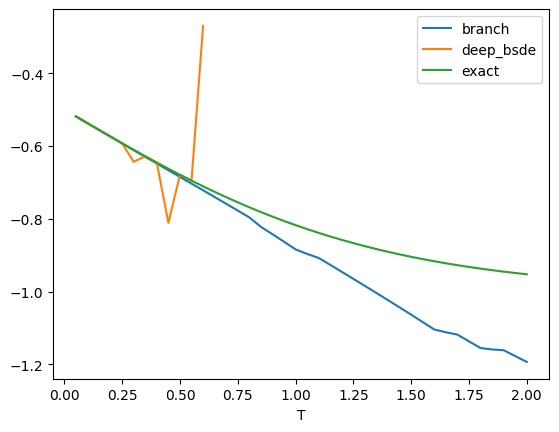

In [7]:
print(df)
df.plot(x='T', y=['branch', 'deep_bsde', 'exact'])

### Dimension d = 10

In [8]:
fixed_dim, dim = 0, 10

problem_name = f"allen_cahn_jeeq_dim_{dim}_blow_up_analysis"

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T, coordinate=0):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

delta_t = 0.05
T_arr = np.arange(delta_t, 2 + delta_t, delta_t)
df = blow_up_analysis(
    T_arr=T_arr,
    dim=dim,
    problem_name=problem_name,
    deriv_map=deriv_map,
    f_example=f_example,
    phi_example=phi_example,
    exact_example=exact_example
)

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.05...


Begin to solve AllenCahn 
Y0_true: -5.1874e-01
relative error of Y0: -0.05%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.1...


Begin to solve AllenCahn 
Y0_true: -5.3743e-01
relative error of Y0: -0.01%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.15000000000000002...


Begin to solve AllenCahn 
Y0_true: -5.5601e-01
relative error of Y0: -0.18%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.2...


Begin to solve AllenCahn 
Y0_true: -5.7444e-01
relative error of Y0: -0.31%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.25...


Begin to solve AllenCahn 
Y0_true: -5.9267e-01
relative error of Y0: -0.19%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.3...


Begin to solve AllenCahn 
Y0_true: -6.1064e-01
relative error of Y0: -0.46%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.35000000000000003...


Begin to solve AllenCahn 
Y0_true: -6.2832e-01
relative error of Y0: -0.44%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.4...


Begin to solve AllenCahn 
Y0_true: -6.4566e-01
relative error of Y0: -0.82%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.45...


Begin to solve AllenCahn 
Y0_true: -6.6262e-01
relative error of Y0: -0.79%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.5...


Begin to solve AllenCahn 
Y0_true: -6.7918e-01
relative error of Y0: -1.17%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.55...


Begin to solve AllenCahn 
Y0_true: -6.9530e-01
relative error of Y0: -0.51%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.6000000000000001...


Begin to solve AllenCahn 
Y0_true: -7.1095e-01
relative error of Y0: -0.72%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.6500000000000001...


Begin to solve AllenCahn 
Y0_true: -7.2611e-01
relative error of Y0: -0.80%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.7000000000000001...


Begin to solve AllenCahn 
Y0_true: -7.4077e-01
relative error of Y0: -0.94%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.7500000000000001...


Begin to solve AllenCahn 
Y0_true: -7.5491e-01
relative error of Y0: -0.75%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.8...


Begin to solve AllenCahn 
Y0_true: -7.6852e-01
relative error of Y0: -0.78%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.8500000000000001...


Begin to solve AllenCahn 
Y0_true: -7.8160e-01
relative error of Y0: -0.94%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.9000000000000001...


Begin to solve AllenCahn 
Y0_true: -7.9413e-01
relative error of Y0: -1.21%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 0.9500000000000001...


Begin to solve AllenCahn 
Y0_true: -8.0612e-01
relative error of Y0: -1.20%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.0...


Begin to solve AllenCahn 
Y0_true: -8.1757e-01
relative error of Y0: -1.21%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.05...


Begin to solve AllenCahn 
Y0_true: -8.2850e-01
relative error of Y0: -19.42%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.1...


Begin to solve AllenCahn 
Y0_true: -8.3889e-01
relative error of Y0: -1.61%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.1500000000000001...


Begin to solve AllenCahn 
Y0_true: -8.4877e-01
relative error of Y0: -1.06%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.2000000000000002...


Begin to solve AllenCahn 
Y0_true: -8.5815e-01
relative error of Y0: -0.79%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.2500000000000002...


Begin to solve AllenCahn 
Y0_true: -8.6704e-01
relative error of Y0: -29.32%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.3...


Begin to solve AllenCahn 
Y0_true: -8.7545e-01
relative error of Y0: -11.31%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.35...


Begin to solve AllenCahn 
Y0_true: -8.8340e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.4000000000000001...


Begin to solve AllenCahn 
Y0_true: -8.9090e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.4500000000000002...


Begin to solve AllenCahn 
Y0_true: -8.9798e-01
relative error of Y0: -22.79%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.5000000000000002...


Begin to solve AllenCahn 
Y0_true: -9.0465e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.55...


Begin to solve AllenCahn 
Y0_true: -9.1093e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.6...


Begin to solve AllenCahn 
Y0_true: -9.1683e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.6500000000000001...


Begin to solve AllenCahn 
Y0_true: -9.2237e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.7000000000000002...


Begin to solve AllenCahn 
Y0_true: -9.2757e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.7500000000000002...


Begin to solve AllenCahn 
Y0_true: -9.3245e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.8...


Begin to solve AllenCahn 
Y0_true: -9.3703e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.85...


Begin to solve AllenCahn 
Y0_true: -9.4131e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.9000000000000001...


Begin to solve AllenCahn 
Y0_true: -9.4532e-01
relative error of Y0: nan%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 1.9500000000000002...


Begin to solve AllenCahn 
Y0_true: -9.4907e-01
relative error of Y0: -19.36%
Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


Now dealing with T = 2.0...


Begin to solve AllenCahn 
Y0_true: -9.5257e-01
relative error of Y0: nan%


       T    branch  deep_bsde     exact  branch time (seconds)  \
0   0.05 -0.518721  -0.518489 -0.518741               1.623524   
1   0.10 -0.537461  -0.537498 -0.537430               1.522849   
2   0.15 -0.556161  -0.556991 -0.556014               1.506693   
3   0.20 -0.574776  -0.576216 -0.574443               1.556297   
4   0.25 -0.593257  -0.593816 -0.592667               1.505259   
5   0.30 -0.611551  -0.613429 -0.610639               1.505652   
6   0.35 -0.629605  -0.631050 -0.628316               1.502957   
7   0.40 -0.647364  -0.650975 -0.645656               1.506912   
8   0.45 -0.664775  -0.667880 -0.662622               1.528547   
9   0.50 -0.686718  -0.687120 -0.679179               1.506093   
10  0.55 -0.705420  -0.698844 -0.695297               1.510978   
11  0.60 -0.724209  -0.716092 -0.710950               1.507232   
12  0.65 -0.743122  -0.731942 -0.726115               1.512470   
13  0.70 -0.762200  -0.747740 -0.740775               1.509127   
14  0.75 -

<AxesSubplot:xlabel='T'>

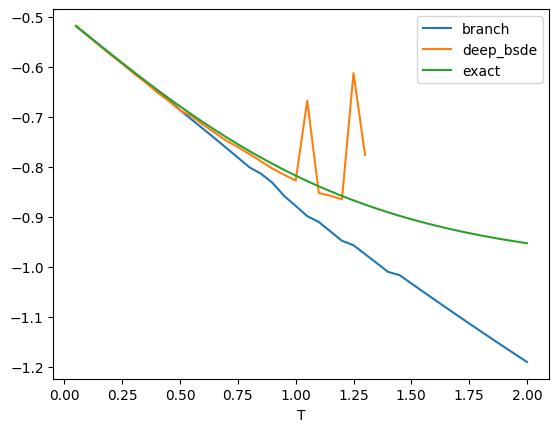

In [9]:
print(df)
df.plot(x='T', y=['branch', 'deep_bsde', 'exact'])

### Dimension d = 100

In [ ]:
fixed_dim, dim = 0, 100

problem_name = f"allen_cahn_jeeq_dim_{dim}_blow_up_analysis"

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T, coordinate=0):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

delta_t = 0.05
T_arr = np.arange(delta_t, 2 + delta_t, delta_t)
df = blow_up_analysis(
    T_arr=T_arr,
    dim=dim,
    problem_name=problem_name,
    deriv_map=deriv_map,
    f_example=f_example,
    phi_example=phi_example,
    exact_example=exact_example
)

print(df)
df.plot(x='T', y=['branch', 'deep_bsde', 'exact'])

## Allen Cahn Equation (5.2) - d = 1, T = 0.5

In [3]:
fixed_dim, dim = 0, 5

problem_name = f"allen_cahn_jeeq_dim_{dim}"

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T, coordinate=0):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

x_lo, x_hi = -8, 8

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


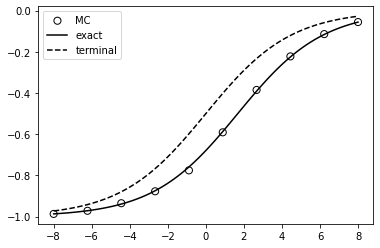

fdb time: 0.0 seconds; total time: 5.2 seconds; time without fdb: 5.2 seconds.


In [4]:
patches = 1
T = patches * .5

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## Allen Cahn Equation (5.2) - d = 100, T = 0.3

In [5]:
fixed_dim, dim = 0, 100

problem_name = f"allen_cahn_jeeq_dim_{dim}"

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T, coordinate=0):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

x_lo, x_hi = -8, 8

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


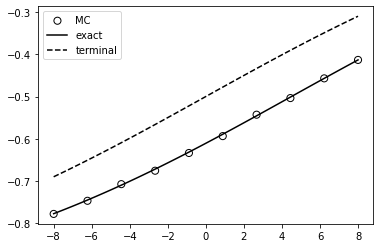

fdb time: 0.0 seconds; total time: 81.5 seconds; time without fdb: 81.4 seconds.


In [6]:
patches = 1
T = patches * .3

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example, repeats=10)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## Exponential Nonlinearity Equation (5.5) - d = 5

In [7]:
fixed_dim, dim = 0, 5
alpha = 10

problem_name = f"exponential_nonlinearity_jeeq_dim_{dim}"

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0      -> no deriv
    idx 1 to d -> first deriv
    """
    return alpha/dim*y[1:].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

def phi_example(x, coordinate=0):
    return torch.log(1 + x.sum(dim=0) ** 2)

def exact_example(t, x, T, coordinate=0):
    return np.log(1 + (x.sum(axis=0) + alpha * (T - t)) ** 2)

x_lo, x_hi = -4, 4

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


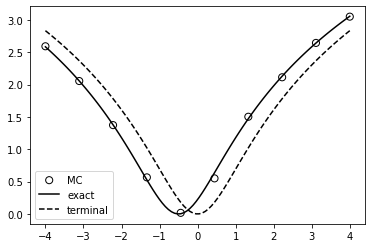

fdb time: 0.2 seconds; total time: 5.1 seconds; time without fdb: 4.9 seconds.


In [8]:
patches = 1
T = patches * .05

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## Exponential Nonlinearity Equation (5.5) - d = 10

In [9]:
fixed_dim, dim = 0, 10
alpha = 10

problem_name = f"exponential_nonlinearity_jeeq_dim_{dim}"

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0      -> no deriv
    idx 1 to d -> first deriv
    """
    return alpha/dim*y[1:].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

def phi_example(x, coordinate=0):
    return torch.log(1 + x.sum(dim=0) ** 2)

def exact_example(t, x, T, coordinate=0):
    return np.log(1 + (x.sum(axis=0) + alpha * (T - t)) ** 2)

x_lo, x_hi = -4, 4

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


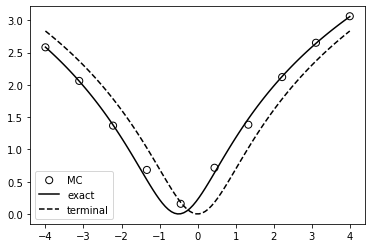

fdb time: 2.5 seconds; total time: 19.9 seconds; time without fdb: 17.5 seconds.


In [10]:
patches = 1
T = patches * .05

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## Dym Equation (5.6)

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


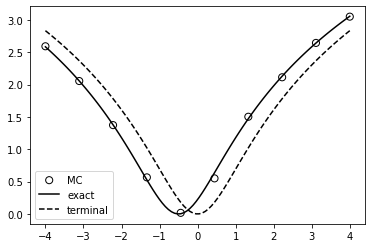

fdb time: 0.2 seconds; total time: 4.5 seconds; time without fdb: 4.3 seconds.


In [13]:
patches = 1
T = patches * .05

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

In [20]:
problem_name = "dym_jeeq"

fixed_dim, dim = 0, 5
alpha = -2

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 2 * np.identity(dim), 3 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0          -> no deriv
    idx 1 to d     -> second deriv
    idx 1+d to 2d  -> third deriv
    """
    return -.5 * y[1:(dim+1)].sum(dim=0) + (y[0] ** 3) * y[(dim+1):].sum(dim=0) / dim

def phi_example(x, coordinate=0):
    ans = (-3 * alpha * x.sum(dim=0))
    return ans.sign() * ans.abs().pow(2/3)

def exact_example(t, x, T, coordinate=0):
    return (-3 * alpha * (x.sum(axis=0) + 4 * alpha**2 * (T - t))) ** (2/3)

x_lo, x_hi = 1, 2

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


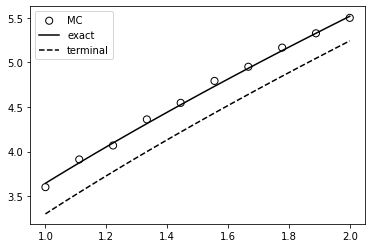

fdb time: 43.6 seconds; total time: 112.9 seconds; time without fdb: 69.2 seconds.


In [21]:
patches = 1
T = patches * .01

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## Quasilinear Nonpolynomial Equation (5.7)

In [22]:
problem_name = "quasilinear_nonpolynomial_jeeq"

fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    """
    return -.5 * y[(dim+1):(2*dim+1)].sum(dim=0) + alpha * y[1:(dim+1)].sum(dim=0) / dim + y[(dim+1):].sum(dim=0) / dim / (1 + y[0] ** 2) - 2 * y[0]

def phi_example(x, coordinate=0):
    return torch.tan(x.sum(dim=0))

def exact_example(t, x, T, coordinate=0):
    return np.tan(x.sum(axis=0) + alpha * (T - t))

x_lo, x_hi = -math.pi/4, math.pi/4

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


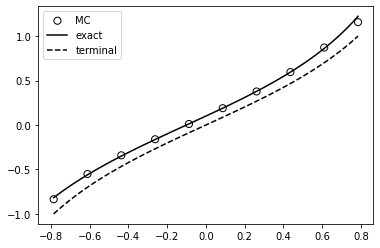

fdb time: 8.1 seconds; total time: 28.1 seconds; time without fdb: 20.0 seconds.


In [23]:
patches = 1
T = patches * .01

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## Cosine Nonlinearity Equation (5.9)

In [24]:
problem_name = "cosine_nonlinearity_jeeq"

fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim), 4 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return -.5 * y[(dim+1):(2*dim+1)].sum(dim=0) + alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim

def phi_example(x, coordinate=0):
    xx = x.sum(dim=0)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

def exact_example(t, x, T, coordinate=0):
    xx = x.sum(axis=0) + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

x_lo, x_hi = -5, 5

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


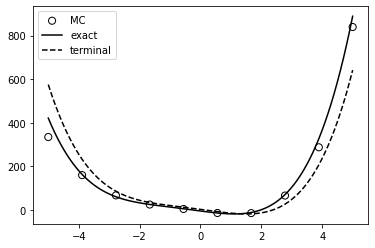

fdb time: 98.4 seconds; total time: 110.6 seconds; time without fdb: 12.1 seconds.


In [25]:
patches = 1
T = patches * .04

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## Log Nonlinearity Equation (5.10)

In [26]:
problem_name = "log_nonlinearity_jeeq"

fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((1 * np.identity(dim), 2 * np.identity(dim), 3 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return -.5 * y[dim:(2*dim)].sum(dim=0) + alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)

def phi_example(x, coordinate=0):
    return torch.cos(x.sum(dim=0))

def exact_example(t, x, T, coordinate=0):
    return np.cos(x.sum(axis=0) + alpha * (T-t))

x_lo, x_hi = -3, 3

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


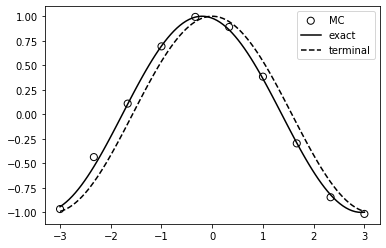

fdb time: 48.5 seconds; total time: 57.1 seconds; time without fdb: 8.6 seconds.


In [28]:
patches = 1
T = patches * .02

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=10000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")